In [1]:
import pandas as pd
import numpy as np
from time import perf_counter
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import utils.dev_config as dev_conf
import utils.preprocessing as prep
import utils.optimization as opt
import utils.feature_selection as feat_sel

In [2]:
dirs = dev_conf.get_dev_directories("../dev_paths.txt")
unified_dsets = ["unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data"]
matrisome_list = f"{dirs.data_dir}/matrisome/matrisome_hs_masterlist.tsv"

In [3]:
i = 0

In [4]:
matrisome_df = prep.load_matrisome_df(matrisome_list)

In [5]:
seed = 123
rand = np.random.RandomState()

In [6]:
def vis_performance(estimator, x, y, random_state):
    train_size = int(x.shape[0] * 2/3)
    test_size = x.shape[0] - train_size
    train_idx = random_state.choice(x.shape[0], size=train_size, replace=False)
    train_mask = np.in1d(np.arange(x.shape[0]), train_idx)
    
    estimator.fit(x[train_mask], y[train_mask])
    yhat = estimator.predict(x[~train_mask])
    
    pred_df = pd.DataFrame({"y": np.squeeze(y[~train_mask].values), "yhat": np.squeeze(yhat)})
    pred_df["obs"] = pred_df.index
    pred_df = pd.melt(pred_df, id_vars=["obs"], value_vars=["y", "yhat"], var_name="y_type", value_name="y_val")
    
    ys = list(zip(np.squeeze(y[~train_mask].values), np.squeeze(yhat)))
    xs = list(range(test_size))
    
    _, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(data=pred_df, x="obs", y="y_val", hue="y_type", ax=ax)
    ax.plot((xs, xs), ([i for (i, j) in ys], [j for (i, j) in ys]), c="black", alpha=0.2)
    return ax

# Load and filter survival data

In [7]:
event_code = {"Alive": 0, "Dead": 1}
covariate_cols = ["figo_stage", "age_at_diagnosis", "race", "ethnicity"]
dep_cols = ["vital_status", "survival_time"]
cat_cols = ["race", "ethnicity", "figo_chr"]
survival_df = prep.load_survival_df(f"{dirs.data_dir}/{unified_dsets[i]}/survival_data.tsv", event_code)

In [8]:
filtered_survival_df = (
    prep.decode_figo_stage(survival_df[["sample_name"] + dep_cols + covariate_cols].dropna(), to="c")
        .query("vital_status == 1")
        .drop(["vital_status"], axis=1)
        .pipe(pd.get_dummies, columns=cat_cols)
        .reset_index(drop = True)
)
filtered_survival_df.columns = filtered_survival_df.columns.str.replace(' ', '_')

print(filtered_survival_df.shape)
# filtered_survival_df.head()

(66, 16)


# Load normalized matrisome count data

In [9]:
norm_matrisome_counts_df = pd.read_csv(f"{dirs.data_dir}/{unified_dsets[i]}/norm_matrisome_counts.tsv", sep='\t')
norm_filtered_matrisome_counts_t_df = prep.transpose_df(
    norm_matrisome_counts_df[["geneID"] + list(filtered_survival_df.sample_name)], "geneID", "sample_name"
)
print(norm_filtered_matrisome_counts_t_df.shape)
# norm_filtered_matrisome_counts_t_df.head()

(66, 1009)


# Join survival and count data

In [10]:
joined_df = (
    pd.merge(filtered_survival_df, norm_filtered_matrisome_counts_t_df, on="sample_name")
        .set_index("sample_name")
)
print(joined_df.shape)
# joined_df.head()

(66, 1023)


# Create models from saved optimizer results

## SVR
Need to do feature permutation importance, since we use a kernel method

In [11]:
svr_h_param_df = pd.read_csv("opt_svr_h_params.tsv", sep="\t")
svr_kwargs = pd.Series(svr_h_param_df.param_value[:-1].values, index=svr_h_param_df.param[:-1]).to_dict()
svr = SVR(
    kernel=svr_kwargs["kernel"],
    C=float(svr_kwargs["C"]),
    epsilon=float(svr_kwargs["epsilon"]),
    gamma=float(svr_kwargs["gamma"]),
    degree=int(svr_kwargs["degree"]),
    coef0=float(svr_kwargs["coef0"])
)
svr_pipeline = make_pipeline(
    ColumnTransformer([
        ("standard", StandardScaler(), ["age_at_diagnosis"] + list(norm_filtered_matrisome_counts_t_df.columns[1:]))
    ], remainder="passthrough"),
    svr
)
svr_ttr = TransformedTargetRegressor(regressor=svr_pipeline, transformer=StandardScaler())

## Gradient Boosted Regressor

In [12]:
gbr_h_param_df = pd.read_csv("opt_gbr_h_params.tsv", sep="\t")
gbr_kwargs = pd.Series(gbr_h_param_df.param_value[:-1].values, index=gbr_h_param_df.param[:-1]).to_dict()
gbr = GradientBoostingRegressor(
    loss=gbr_kwargs["loss"],
    learning_rate=float(gbr_kwargs["learning_rate"]),
    n_estimators=int(gbr_kwargs["n_estimators"]),
    max_depth=int(gbr_kwargs["max_depth"]),
    max_features=gbr_kwargs["max_features"],
    alpha=float(gbr_kwargs["alpha"]),
    random_state=rand
)

gbr_pipeline = make_pipeline(
    ColumnTransformer([
        ("standard", StandardScaler(), ["age_at_diagnosis"] + list(norm_filtered_matrisome_counts_t_df.columns[1:]))
    ], remainder="passthrough"),
    gbr
)
gbr_ttr = TransformedTargetRegressor(regressor=gbr_pipeline, transformer=StandardScaler())

# Collect cross validated feature permutation results
$baseline - perm\_score > 0 \Longrightarrow \text{feature permutation reduces performance} \Longrightarrow \text{feature is important}$

EX:

$baseline\_neg\_MAE = -500, \; perm\_neg\_MAE = -510$

$\Longrightarrow -500 -(-510) = 10 > 0 \Longrightarrow perm\_importance > 0 \Longrightarrow \text{feature is important}$

In [13]:
rand.seed(seed)
x_df, y_df = prep.shuffle_data(joined_df, rand)
svr_perm_res, svr_ref_scores = opt.cv_permutation_importance(svr_ttr, x_df, y_df, "neg_mean_absolute_error", random_state=rand)

In [14]:
svr_perm_imp = np.concatenate([
    (r.importances) for r in svr_perm_res
], axis=1)
svr_imp_meds = np.median(svr_perm_imp, axis=1)
svr_imp_means = np.mean(svr_perm_imp, axis=1)

# Assuming each feature was equally important, we would expect them to influence the reference metric by this value
svr_ref_score_mean = svr_ref_scores.mean()
svr_ref_score_med = np.median(svr_ref_scores)
svr_naive_ref_score = -mean_absolute_error(y_df.values, np.repeat(np.median(y_df.values), y_df.shape[0])[:, np.newaxis])
(svr_ref_score_mean - svr_naive_ref_score) / np.abs(svr_naive_ref_score) * 100

4.105887984196447

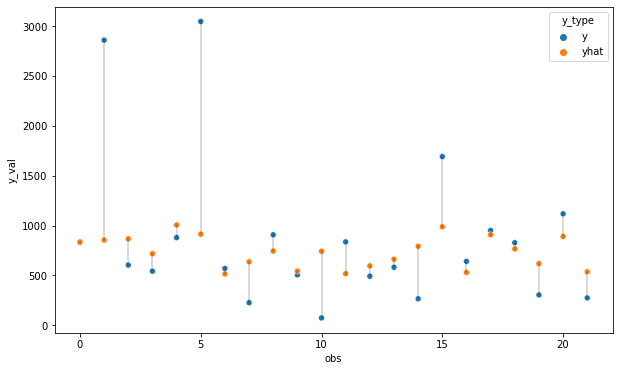

In [15]:
ax = vis_performance(svr_ttr, x_df, y_df, rand)
plt.show()

In [16]:
svr_perm_res_df = feat_sel.gather_perm_res(x_df, svr_imp_means, svr_ref_score_mean, norm_filtered_matrisome_counts_t_df.columns[1:])

In [17]:
rand.seed(seed)
x_df, y_df = prep.shuffle_data(joined_df, rand)
gbr_perm_res, gbr_ref_scores = opt.cv_permutation_importance(gbr_ttr, x_df, y_df, "neg_mean_absolute_error", random_state=rand)

In [18]:
gbr_perm_imp = np.concatenate([
    (r.importances) for r in gbr_perm_res
], axis=1)
gbr_imp_meds = np.median(gbr_perm_imp, axis=1)
gbr_imp_means = np.mean(gbr_perm_imp, axis=1)

# Assuming each feature was equally important, we would expect them to influence the reference metric by this value
gbr_ref_score_mean = gbr_ref_scores.mean()
gbr_ref_score_med = np.median(gbr_ref_scores)
gbr_naive_ref_score = -mean_absolute_error(y_df.values, np.repeat(np.median(y_df.values), y_df.shape[0])[:, np.newaxis])
(gbr_ref_score_mean - gbr_naive_ref_score) / np.abs(gbr_naive_ref_score) * 100

6.373824650133302

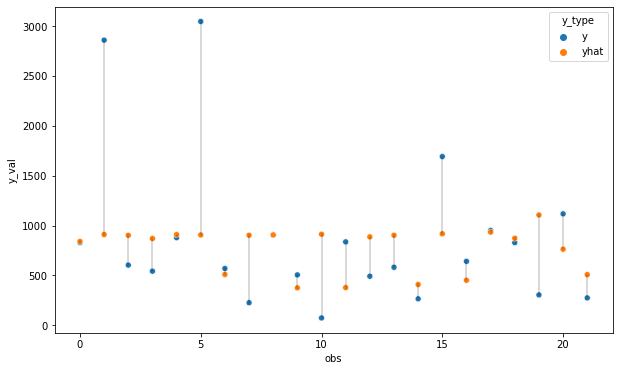

In [19]:
ax = vis_performance(gbr_ttr, x_df, y_df, rand)
plt.show()

In [20]:
gbr_perm_res_df = feat_sel.gather_perm_res(x_df, gbr_imp_means, gbr_ref_score_mean, norm_filtered_matrisome_counts_t_df.columns[1:])

# GBR seems to react much more strongly to feature permutation than SVR

In [21]:
svr_perm_res_df.sort_values("mean_imp", ascending=False)

,geneID,mean_imp,score_pct_improvement
166,ADAM18,1.099040,0.221112
780,BMP3,0.971043,0.195361
833,MUC4,0.881463,0.177338
150,COLEC11,0.858821,0.172783
944,COL11A1,0.790634,0.159065
...,...,...,...
618,REG3A,-0.647710,-0.130311
854,CST8,-0.652712,-0.131317
394,CFC1B,-0.664847,-0.133758
397,VWA5B1,-1.295868,-0.260711


In [22]:
gbr_perm_res_df.sort_values("mean_imp", ascending=False)

,geneID,mean_imp,score_pct_improvement
981,HMCN2,28.668377,5.907404
91,ADAMTS15,12.805571,2.638715
13,ANGPT2,12.012834,2.475364
528,HYAL3,11.796667,2.430821
396,AMBP,11.147836,2.297122
...,...,...,...
939,LEPRE1,-1.909024,-0.393373
201,FGF10,-2.215113,-0.456446
231,IGFBPL1,-2.325878,-0.479270
232,SERPINB1,-2.554578,-0.526396


In [23]:
svr_perm_res_df.to_csv(f"{dirs.analysis_dir}/{unified_dsets[i]}_svr_permutation_results.tsv", sep="\t", index=False)
gbr_perm_res_df.to_csv(f"{dirs.analysis_dir}/{unified_dsets[i]}_gbr_permutation_results.tsv", sep="\t", index=False)